In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
# Apply the default theme
sns.set_theme()

import os
from pathlib import Path
import itertools

from data import name_to_dataset

RESULTS_PATH = 'results/'

MODELS = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree',
    'RandomForest2',
    'RandomForest4',
    'RandomForest8',
    'RandomForest16',
    'RandomForest',
    'XGBoost',
    'MLP'
    ]

HIER_TYPES = ['rsa', 'ras', 'asr', 'ers', 'esr', 'res', 'rse']
HIER_STATES = ['CA', 'NY', 'TX', 'MI', 'WY', 'WI', 'IN', 'FL']
HIER_TASKS = ['income', 'coverage', 'employment']

# RACE-AGE-SEX intersections
dataset_ras = name_to_dataset('income_CA_ras')
ras_groups = dataset_ras.group_names
ras_tree = dataset_ras.tree
ras_lvl1 = [ras_groups[i] for i in ras_tree[0] + ras_tree[1]]
ras_lvl2 = [ras_groups[i] for i in ras_tree[2]]
ras_lvl3 = [ras_groups[i] for i in ras_tree[3]]

# RACE-SEX-AGE intersections
dataset_rsa = name_to_dataset('income_CA_rsa')
rsa_groups = dataset_rsa.group_names
rsa_tree = dataset_rsa.tree
rsa_lvl1 = [rsa_groups[i] for i in rsa_tree[0] + rsa_tree[1]]
rsa_lvl2 = [rsa_groups[i] for i in rsa_tree[2]]
rsa_lvl3 = [rsa_groups[i] for i in rsa_tree[3]]

# AGE-SEX-RACE intersections
dataset_asr = name_to_dataset('income_CA_asr')
asr_groups = dataset_asr.group_names
asr_tree = dataset_asr.tree
asr_lvl1 = [asr_groups[i] for i in asr_tree[0] + asr_tree[1] + asr_tree[2]]
asr_lvl2 = [asr_groups[i] for i in asr_tree[3]]

In [3]:
def load_error_results(dataset, model, group_names):
    path = os.path.join(os.path.join(RESULTS_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = group_names
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    raw_results = torch.load(path)

    # Convert format of results
    return_dict['results'] = {}
    result_keys = ['ERM_ALL', 'ERM_GROUP', 'TREE', 'PREPEND']
    for g in groups:
        erm_all_results = raw_results[g]['ERM_ALL']
        if erm_all_results[0] == -1: # indicator that group was empty
            return_dict['results'][g] = {}
            for method in result_keys:
                return_dict['results'][g][method] = (0, 0)
        else:
            return_dict['results'][g] = {}
            for method in result_keys:
                results = raw_results[g][method]
                err = results[0] - results[1][0]
                return_dict['results'][g][method] = (results[0], err)
    return return_dict
    """
    erm_all_err = erm_all_results[0] - erm_all_results[1][0]
    erm_group_results = raw_results[g]['ERM_GROUP']
    erm_group_err = erm_group_results[0] - erm_group_results[1][0]
    prep_group_results = raw_results[g]['PREPEND']
    prep_group_err = prep_group_results[0] - prep_group_results[1][0]
    erm_tree_results = raw_results[g]['TREE']
    erm_tree_err = erm_tree_results[0] - erm_tree_results[1][0]

    return_dict['results'][g] = {}
    return_dict['results'][g]['ERM_ALL'] = (erm_all_results[0], erm_all_err)
    return_dict['results'][g]['ERM_GROUP'] = (erm_group_results[0], erm_group_err)
    return_dict['results'][g]['TREE'] = (erm_tree_results[0], erm_tree_err)
    """

In [4]:
def dataset_error_df(models, dataset, groups):
    """
    Creates a dataframe for each fixed dataset with the error data for each model. Columns are the groups, rows are the models.
    """
    # Construct columns
    rows = []
    for model in models:
        rows.append("{} (ERM)".format(model))
        rows.append("{} (G-ERM)".format(model))
        rows.append("{} (PREP)".format(model))
        rows.append("{} (TREE)".format(model))
    df = pd.DataFrame(index=rows, columns=groups)
    df_errs = pd.DataFrame(columns=groups)

    for model in models:
        results = load_error_results(dataset, model, groups)
        group_errors = results['results']
        erm_row = []
        erm_row_err = []
        germ_row = []
        germ_row_err = []
        prep_row = []
        prep_row_err = []
        tree_row = []
        tree_row_err = []
        for g in groups:
            erm_row.append(group_errors[g]['ERM_ALL'][0])
            erm_row_err.append(group_errors[g]['ERM_ALL'][1])
            germ_row.append(group_errors[g]['ERM_GROUP'][0])
            germ_row_err.append(group_errors[g]['ERM_GROUP'][1])
            prep_row.append(group_errors[g]['PREPEND'][0])
            prep_row_err.append(group_errors[g]['PREPEND'][1])
            tree_row.append(group_errors[g]['TREE'][0])
            tree_row_err.append(group_errors[g]['TREE'][1])

        df.loc["{} (ERM)".format(model)] = erm_row
        df_errs.loc["{} (ERM) err".format(model)] = erm_row_err
        df.loc["{} (G-ERM)".format(model)] = germ_row
        df_errs.loc["{} (G-ERM) err".format(model)] = germ_row_err
        df.loc["{} (PREP)".format(model)] = prep_row
        df_errs.loc["{} (PREP) err".format(model)] = prep_row_err
        df.loc["{} (TREE)".format(model)] = tree_row
        df_errs.loc["{} (TREE) err".format(model)] = tree_row_err

    df = pd.concat([df, df_errs])
    return df

def plot_error(ax, data, models, groups, 
               group_names=None, title=None, legend=False):
    # Preprocess the data into a vertical DF
    rows = []
    for (group, model) in itertools.product(groups, models):
        row = {}
        row['group'] = group
        row['model'] = model
        row['error'] = data.loc[group][model]
        err = data.loc[group]["{} err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[group][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)

    # Plot the data
    err = []
    lerr = df.pivot(index='group', columns='model', values='lerr')
    uerr = df.pivot(index='group', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='group', columns='model', values='error')

    # Rename the index
    renamed_idx = {}
    for i, g in enumerate(groups):
        renamed_idx[g] = group_names[i]
    p = p.rename(index=renamed_idx)
    ax = p.plot(kind='bar', yerr=err, ax=ax, legend=False)
    ax.set_ylabel('test error')
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(loc='lower center', frameon=False, ncols=4, bbox_to_anchor=(0, -1.0, 0.5, 0.5))
    return ax

In [4]:
# Create a DF for each dataset
DF_PATH = os.path.join(RESULTS_PATH, 'dfs')
dataset_dfs_error = {}

# Get all dataset combos we care about

# TODO: THIS IS NO LONGER SLOW!!! So we can just convert to a dataframe on the fly!!!
for dataset in HIER_DATASETS:
    path = os.path.join(DF_PATH, "{}.csv".format(dataset))
    hier_type = dataset.split('_')[2]
    try:
        dataset_dfs_error[dataset] = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        ras_group_indices = list(range(len(ras_groups)))
        rsa_group_indices = list(range(len(rsa_groups)))
        asr_group_indices = list(range(len(asr_groups)))
        if hier_type == 'ras':
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                        ras_group_indices)
        elif hier_type == 'rsa':
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                        rsa_group_indices)
        elif hier_type == 'asr':
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                        asr_group_indices)
        else:
            raise ValueError("{} not a valid dataset type!".format(hier_type))
        dataset_dfs_error[dataset].to_csv(path)

## Race-Sex-Age Hierarchical Groups

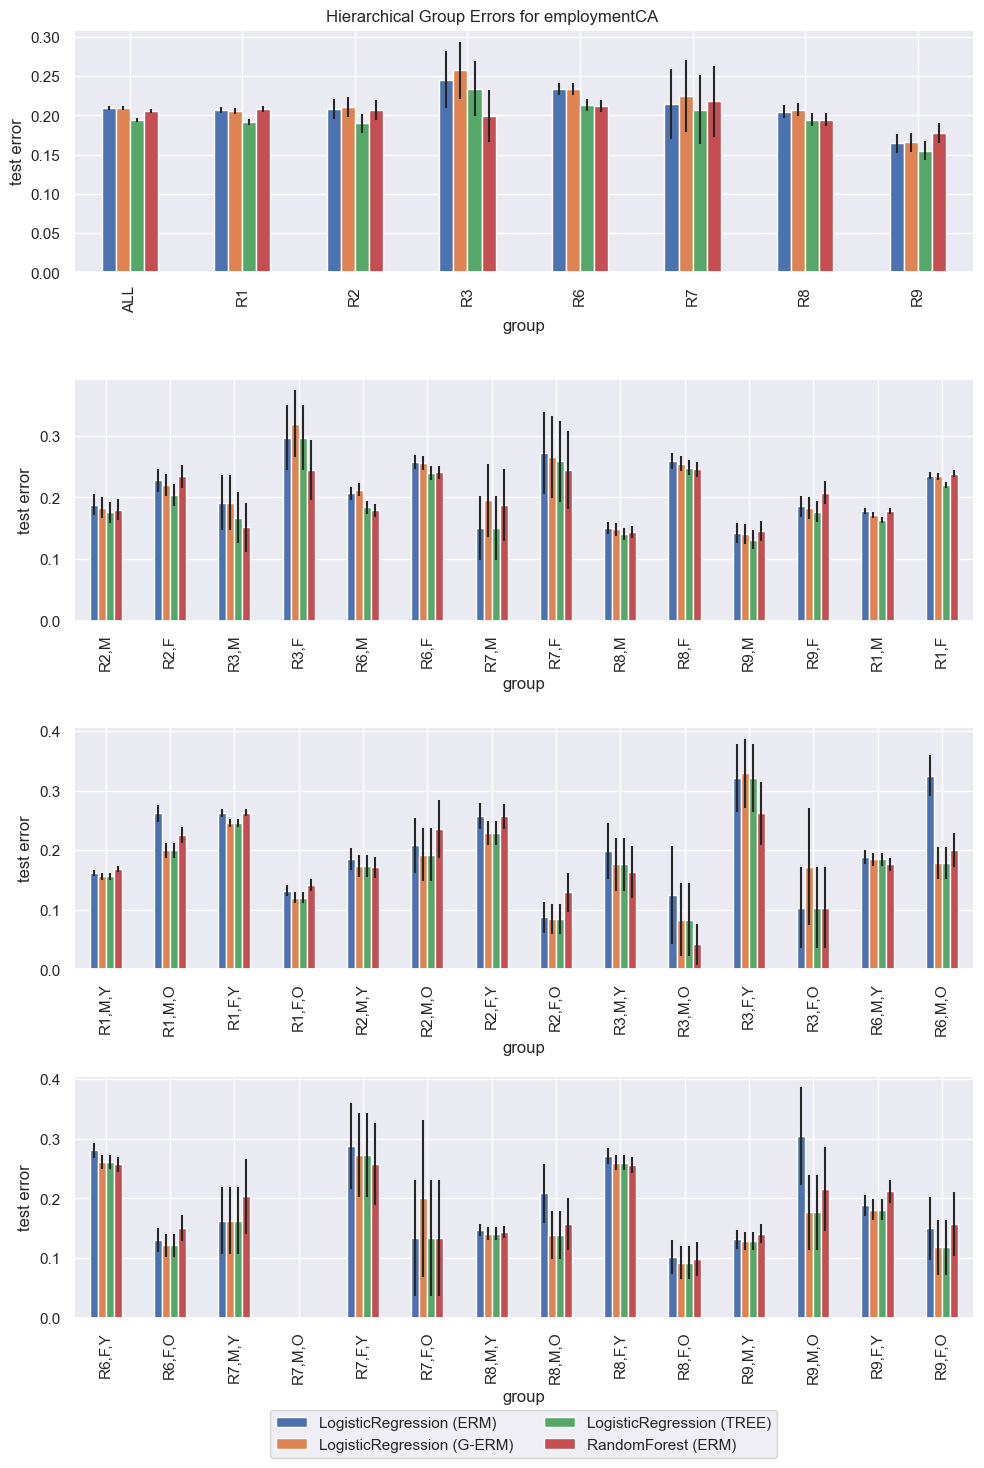

In [5]:
data_name = 'employmentCA'
data = dataset_dfs_error['{}_rsa'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in rsa_tree[0] + rsa_tree[1]], 
                rsa_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in rsa_tree[2]], 
                rsa_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                    [groups[i] for i in rsa_tree[3][:14]], 
                rsa_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in rsa_tree[3][14:]], 
                rsa_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

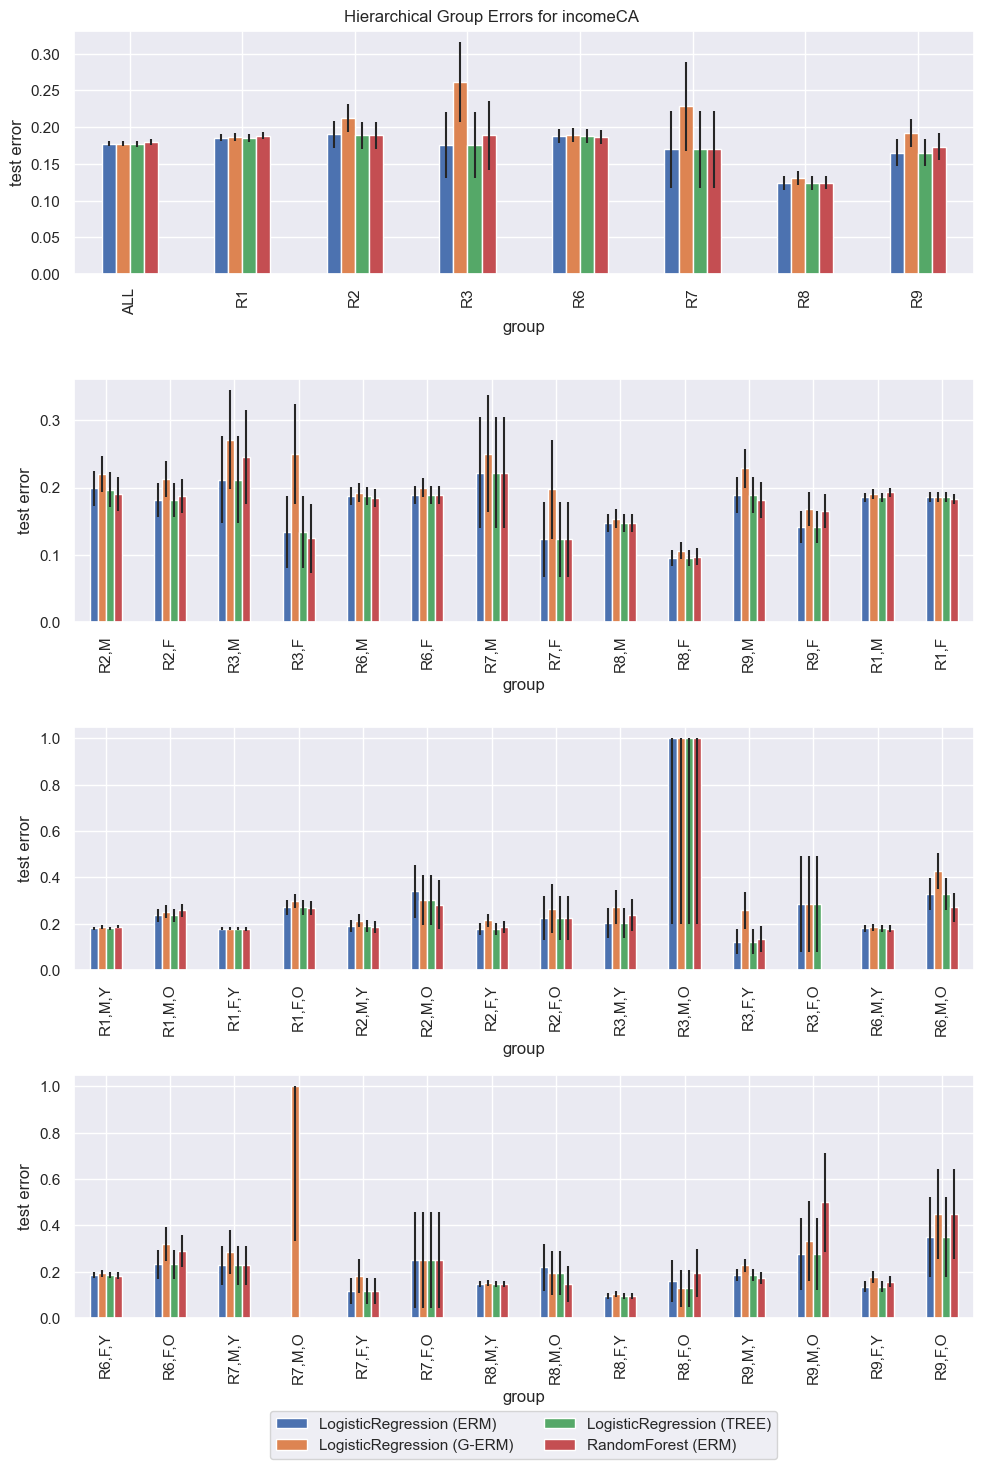

In [6]:
data_name = 'incomeCA'
data = dataset_dfs_error['{}_rsa'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in rsa_tree[0] + rsa_tree[1]], 
                rsa_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in rsa_tree[2]], 
                rsa_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in rsa_tree[3][:14]], 
                rsa_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in rsa_tree[3][14:]], 
                rsa_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

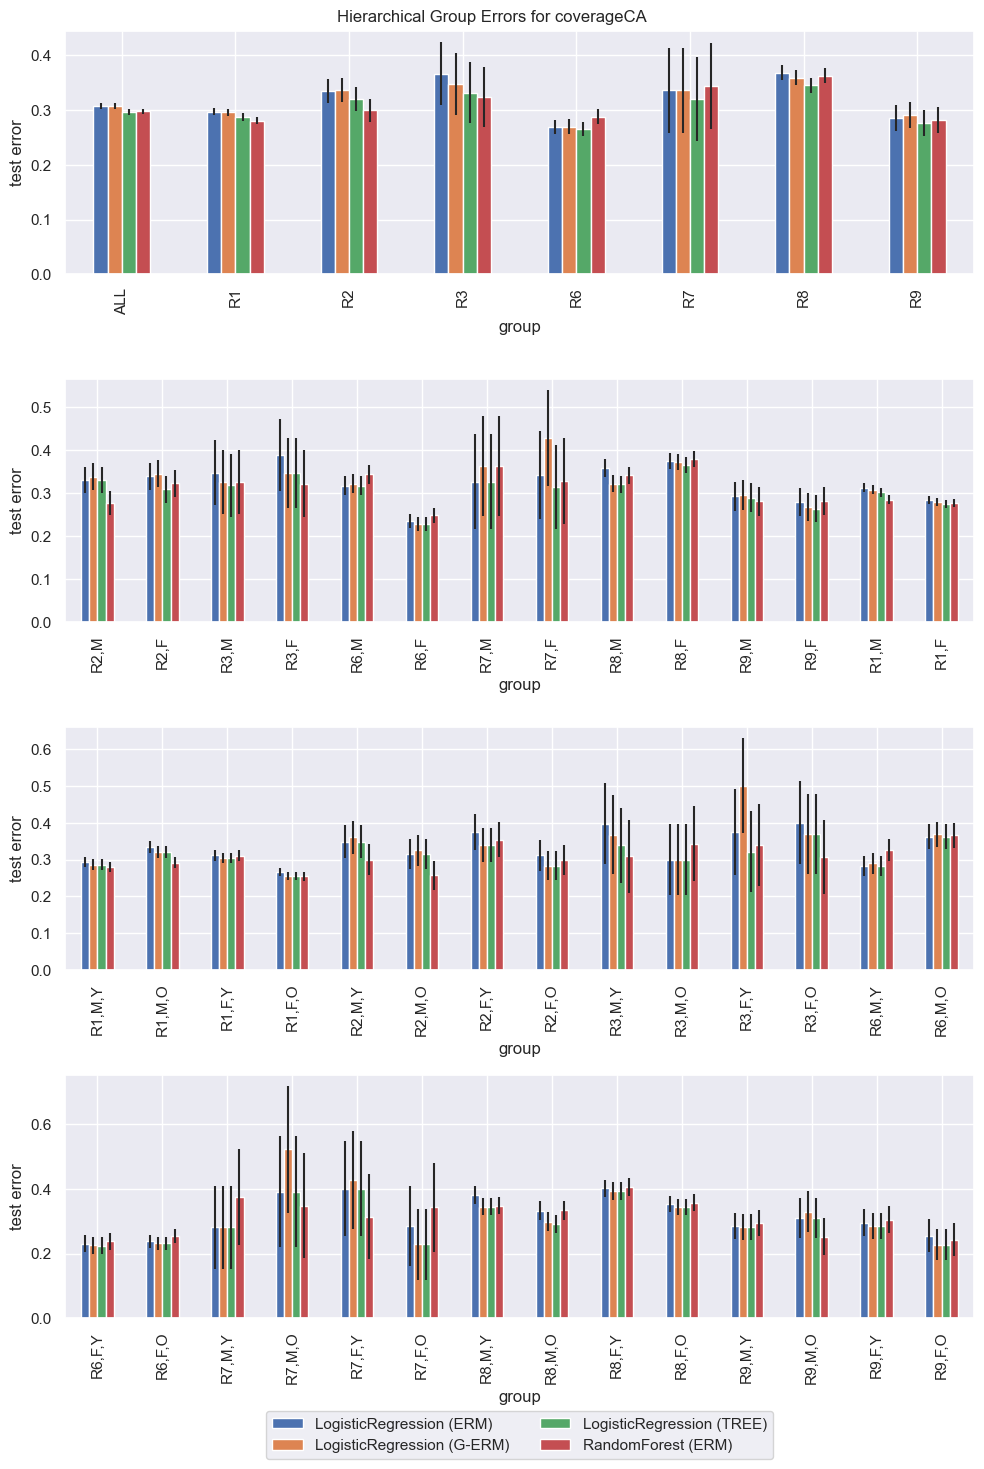

In [7]:
data_name = 'coverageCA'
data = dataset_dfs_error['{}_rsa'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in rsa_tree[0] + rsa_tree[1]], 
                rsa_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in rsa_tree[2]], 
                rsa_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in rsa_tree[3][:14]], 
                rsa_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in rsa_tree[3][14:]], 
                rsa_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

## Race-Age-Sex Hierarchical Groups

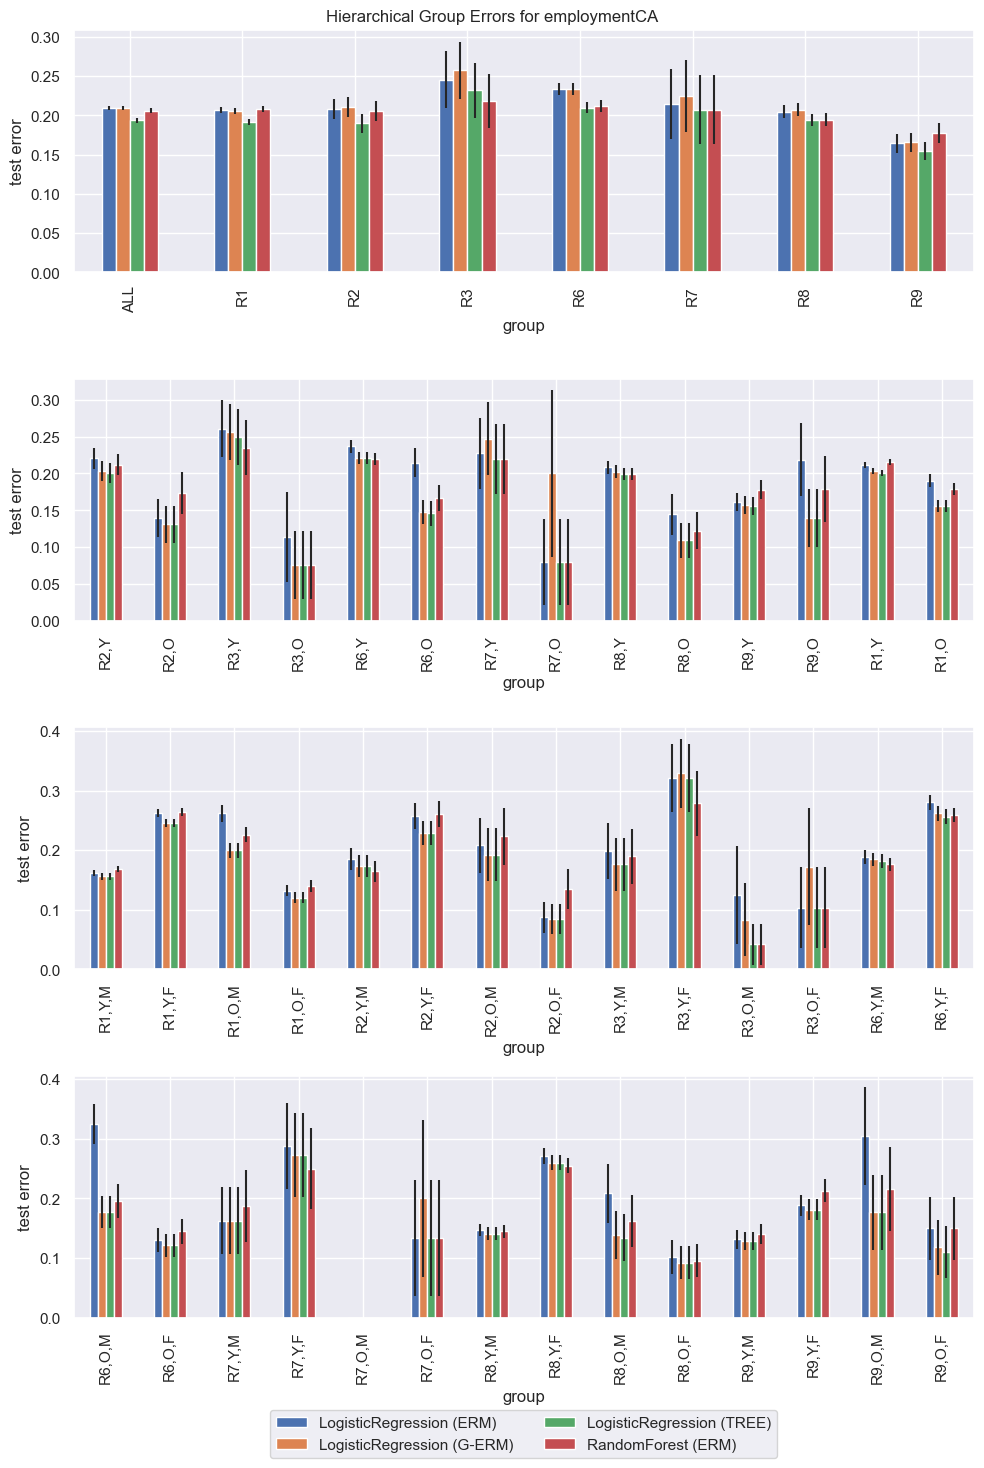

In [8]:
data_name = 'employmentCA'
data = dataset_dfs_error['{}_ras'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in ras_tree[0] + ras_tree[1]], 
                ras_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in ras_tree[2]], 
                ras_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in ras_tree[3][:14]], 
                ras_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in ras_tree[3][14:]], 
                ras_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

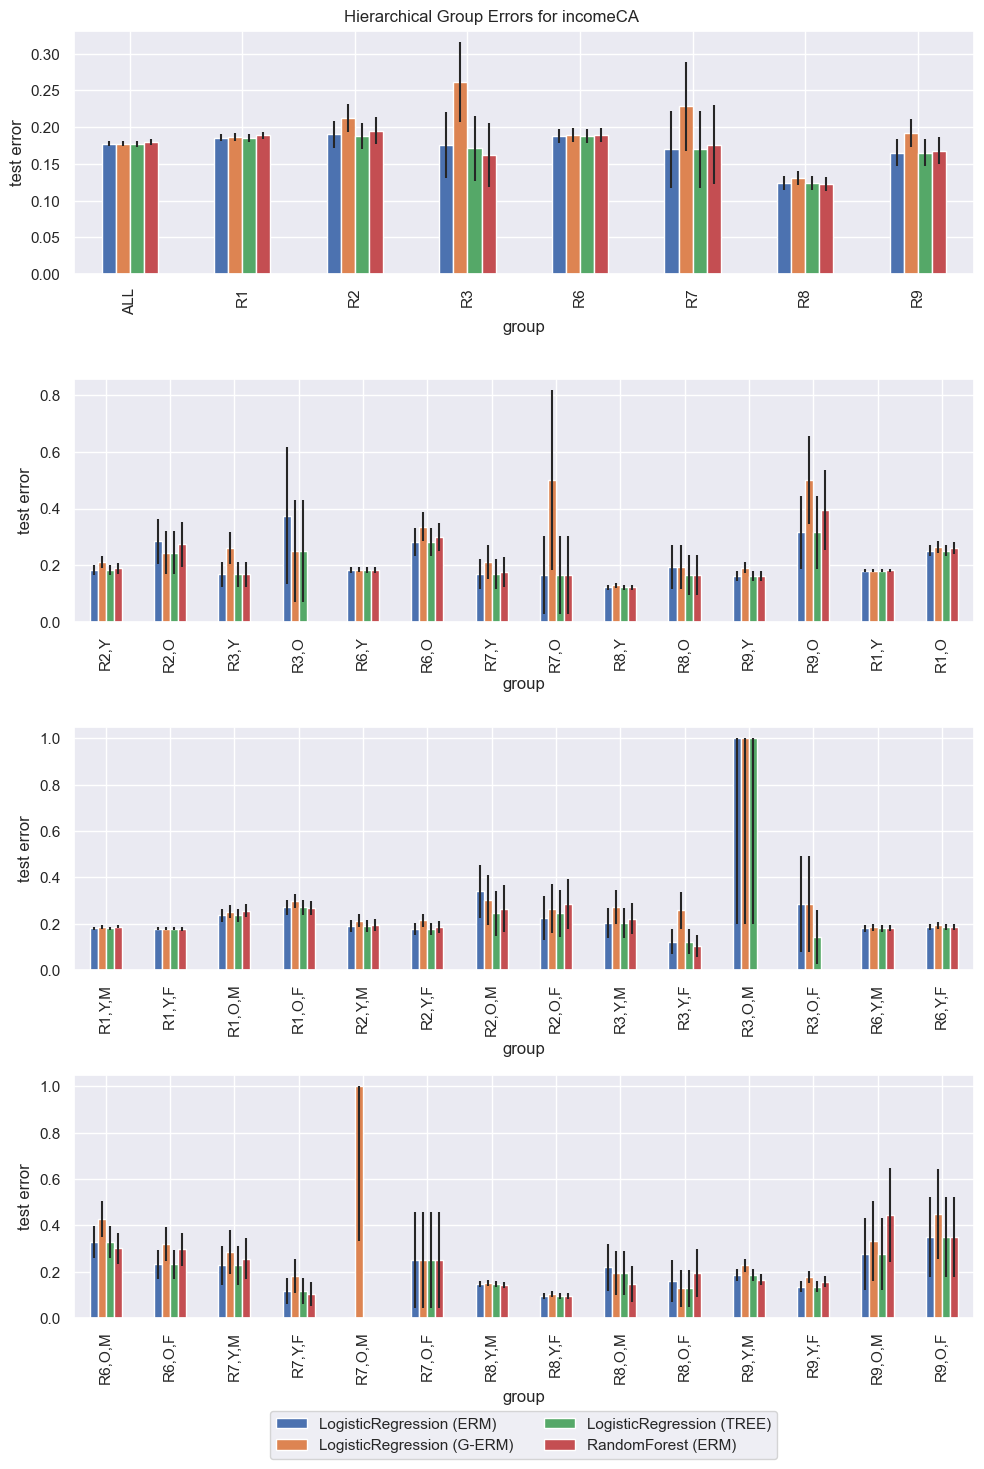

In [9]:
data_name = 'incomeCA'
data = dataset_dfs_error['{}_ras'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in ras_tree[0] + ras_tree[1]], 
                ras_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in ras_tree[2]], 
                ras_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in ras_tree[3][:14]], 
                ras_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in ras_tree[3][14:]], 
                ras_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

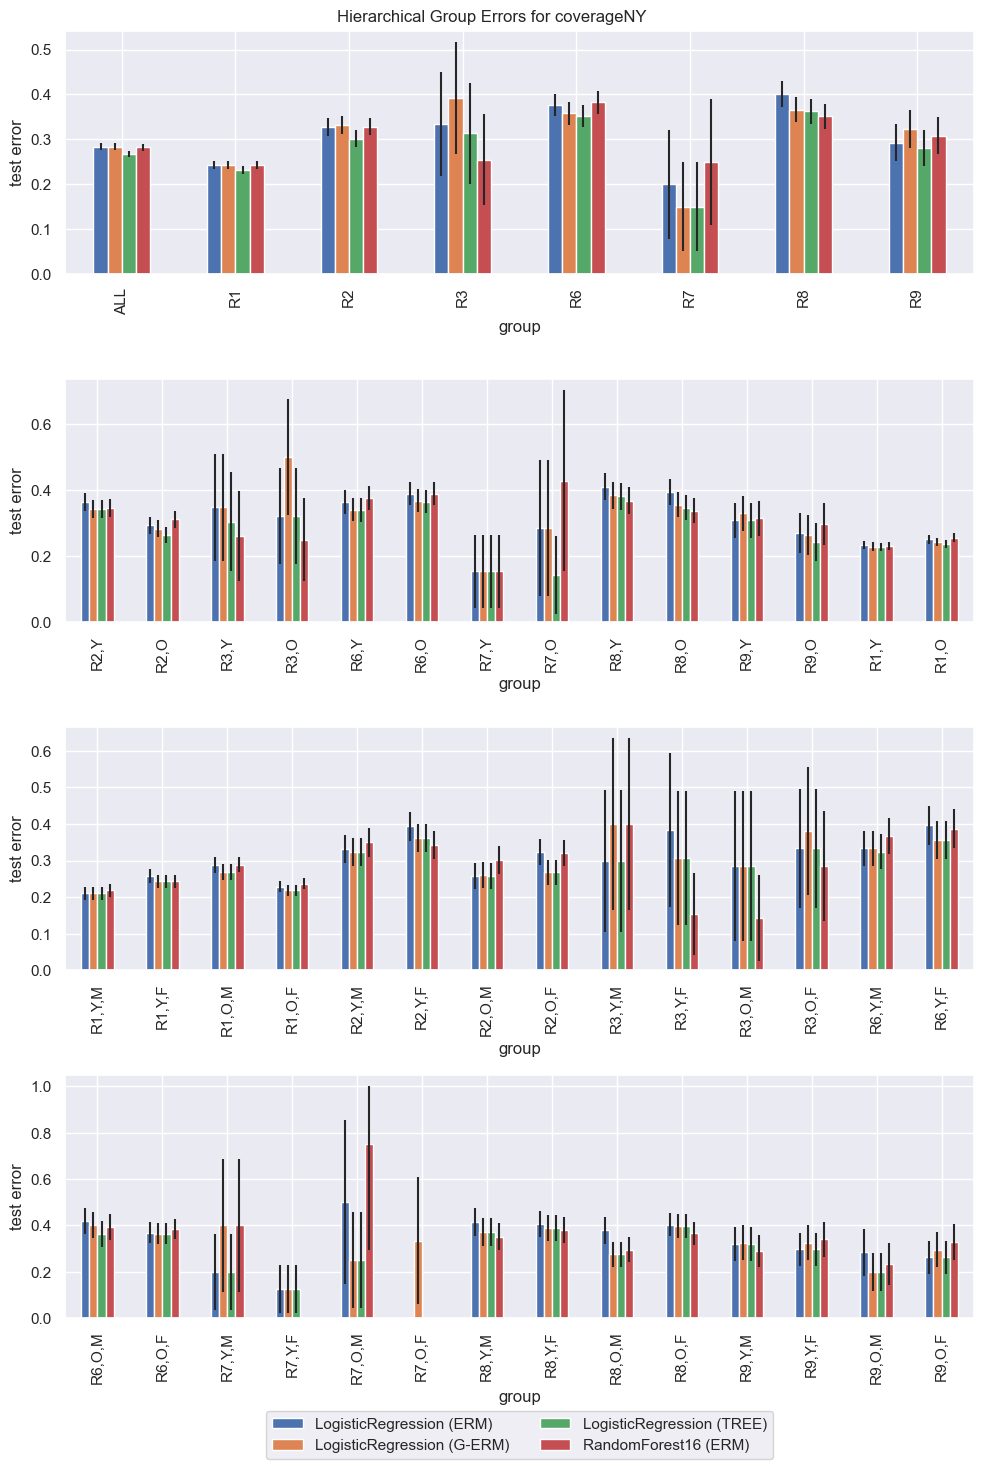

In [25]:
data_name = 'coverageNY'
data = dataset_dfs_error['{}_ras'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest16 (ERM)']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in ras_tree[0] + ras_tree[1]], 
                ras_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in ras_tree[2]], 
                ras_lvl2, title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in ras_tree[3][:14]], 
                ras_lvl3[:14], title=None, legend=False)
axs[3] = plot_error(axs[3], data, models, 
                [groups[i] for i in ras_tree[3][14:]], 
                ras_lvl3[14:], title=None, legend=False)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

## Age-Sex-Race Hierarchical Groups

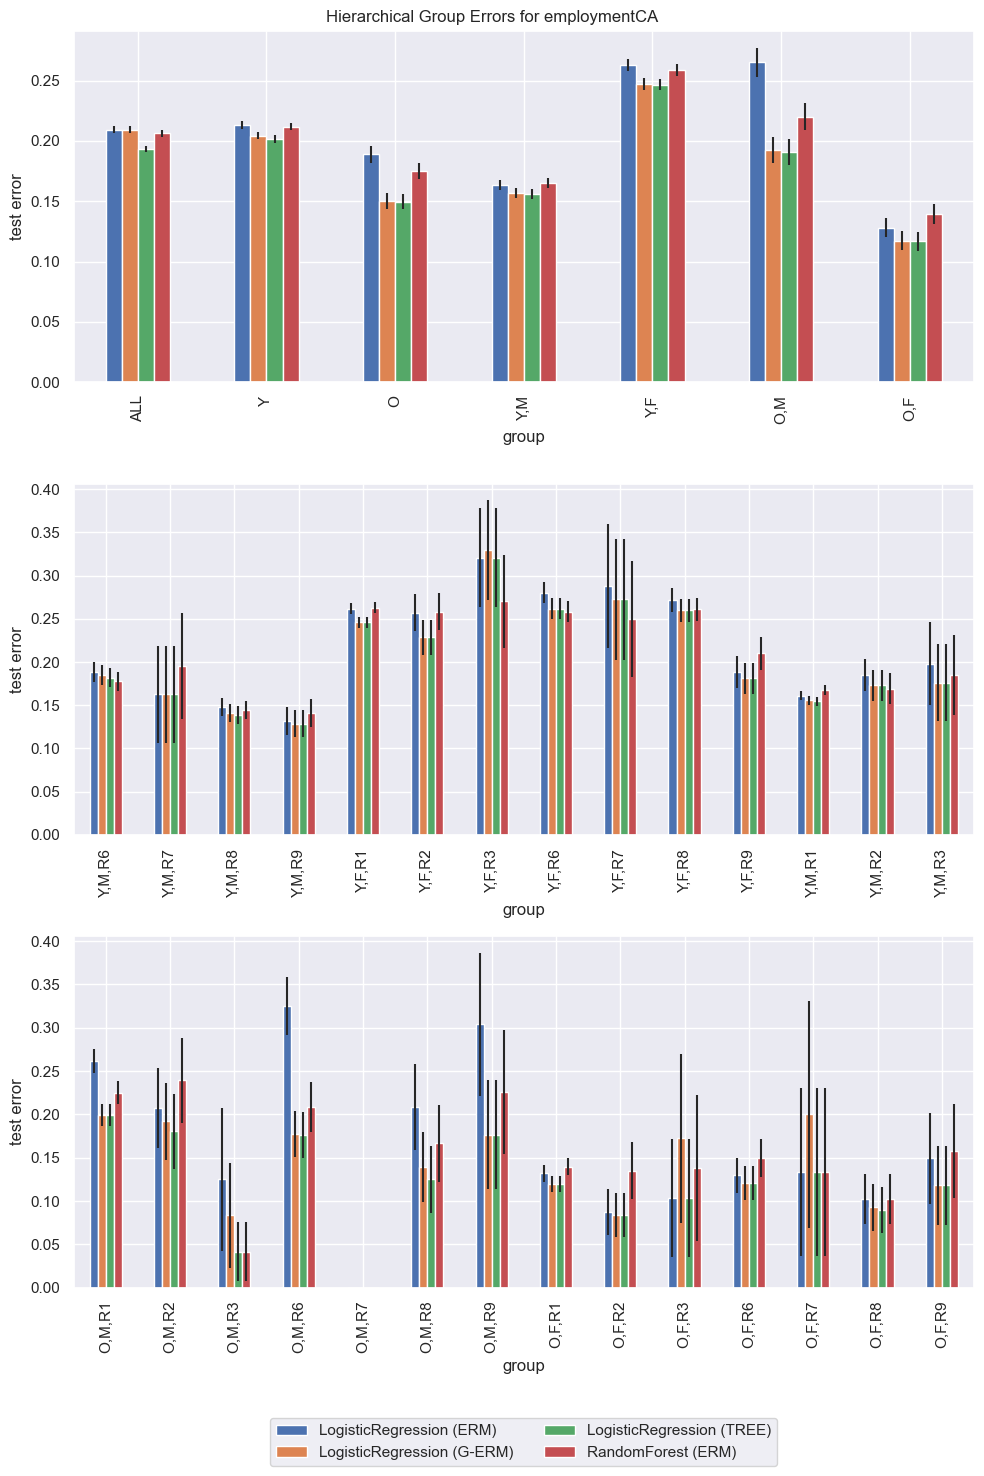

In [11]:
data_name = 'employmentCA'
data = dataset_dfs_error['{}_asr'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in asr_tree[0] + asr_tree[1] + asr_tree[2]], 
                asr_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in asr_tree[3]][:14], 
                asr_lvl2[:14], title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in asr_tree[3]][14:], 
                asr_lvl2[14:], title=None, legend=False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

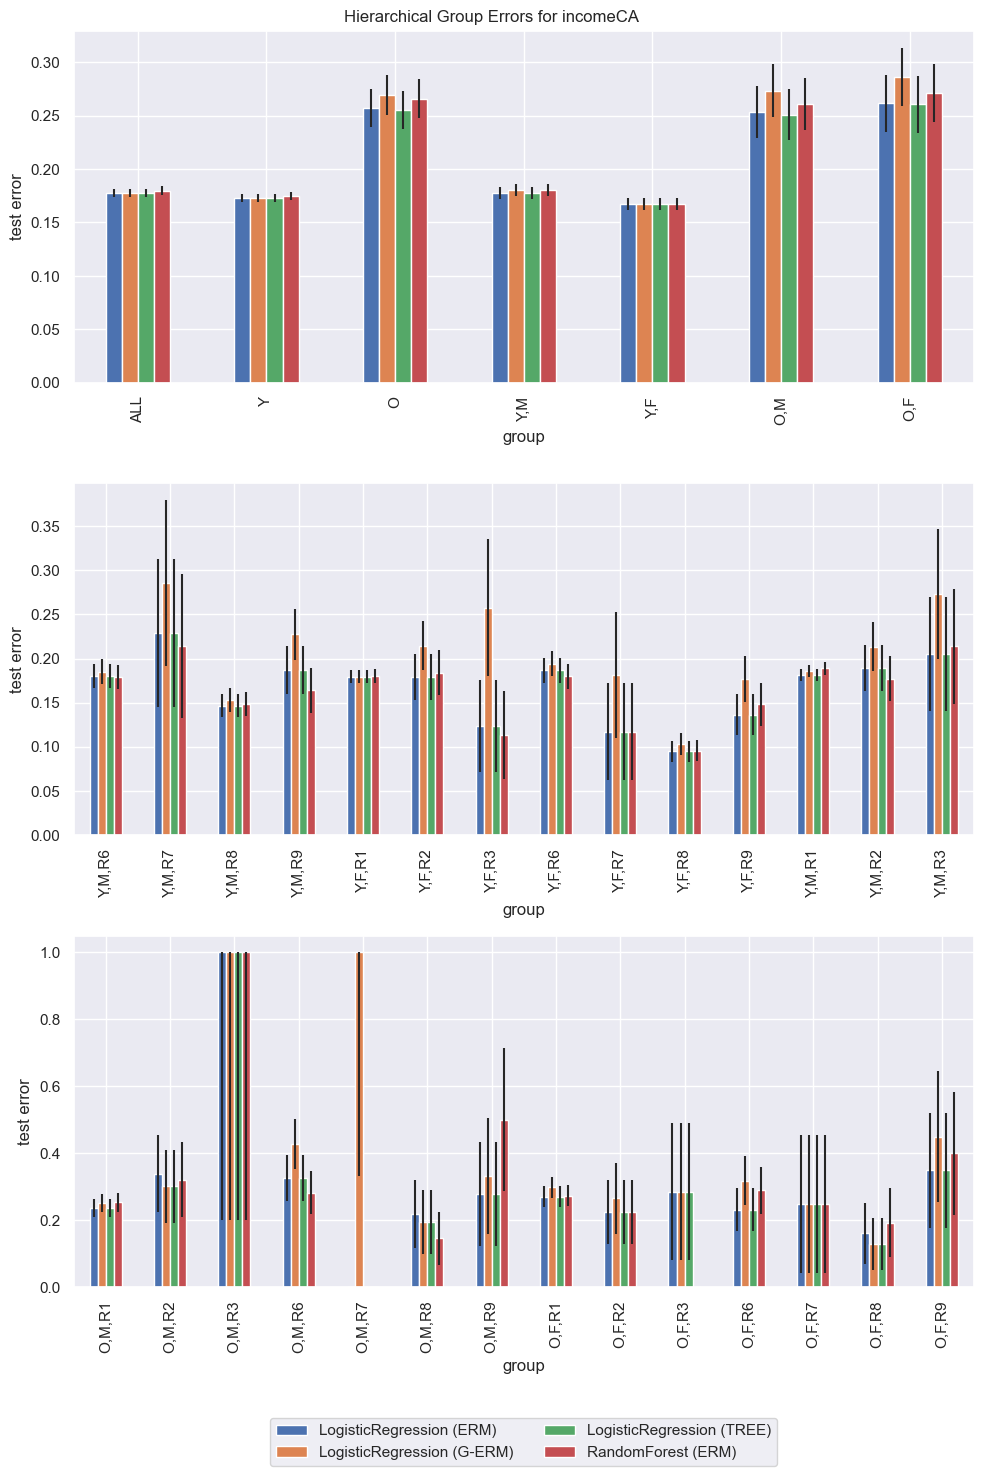

In [16]:
data_name = 'incomeCA'
data = dataset_dfs_error['{}_asr'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in asr_tree[0] + asr_tree[1] + asr_tree[2]], 
                asr_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in asr_tree[3]][:14], 
                asr_lvl2[:14], title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in asr_tree[3]][14:], 
                asr_lvl2[14:], title=None, legend=False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()

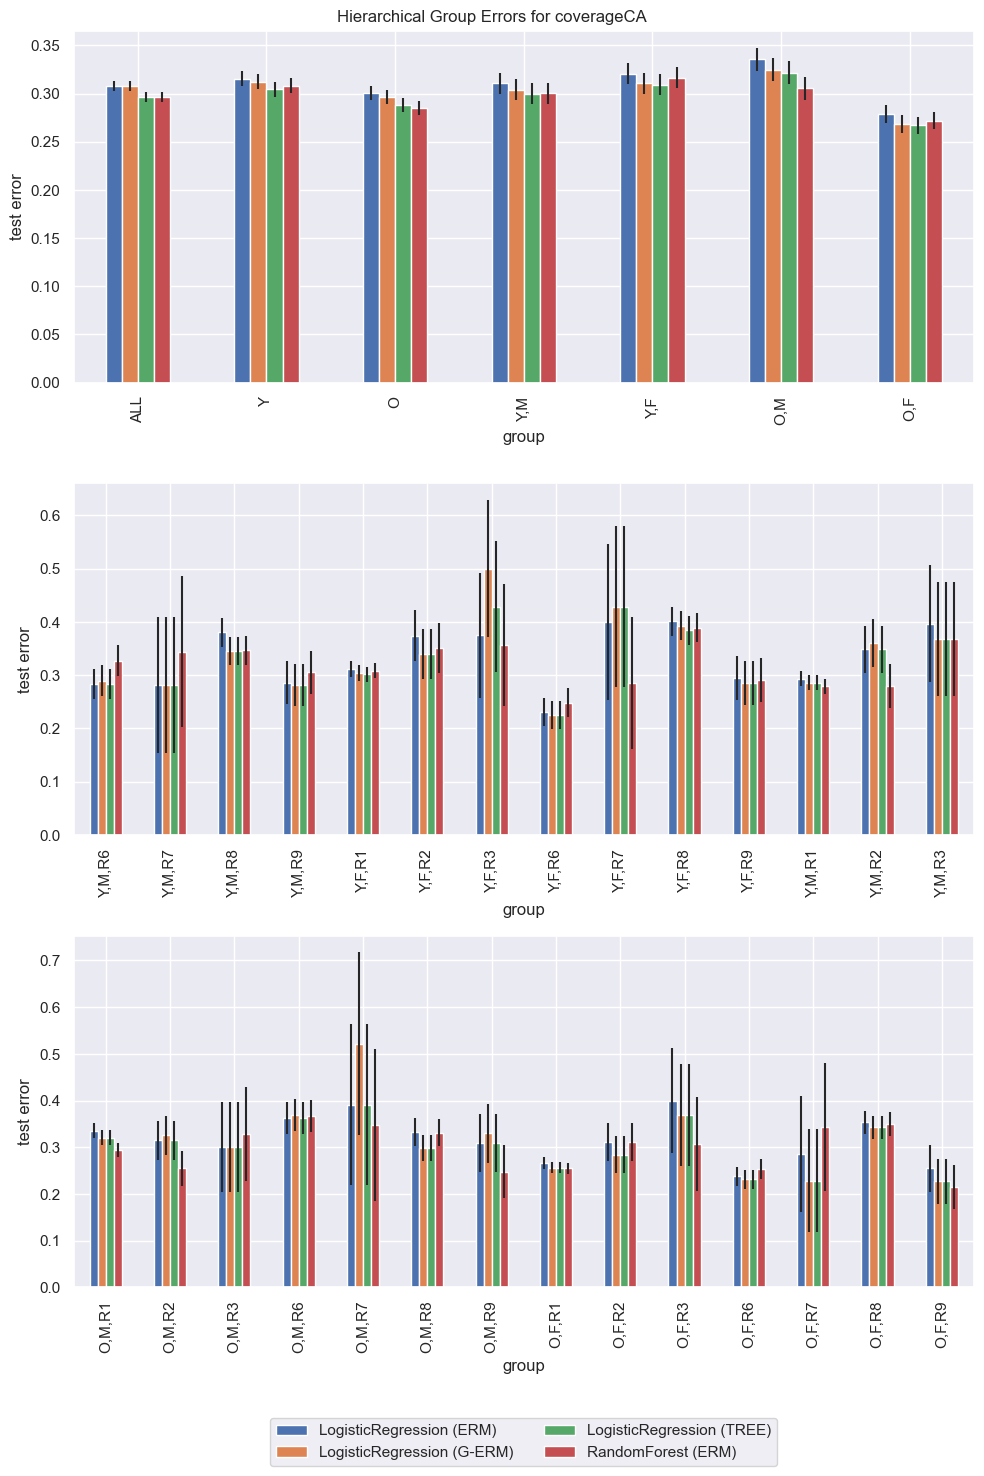

In [13]:
data_name = 'coverageCA'
data = dataset_dfs_error['{}_asr'.format(data_name)].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 
          'LogisticRegression (G-ERM)', 
          'LogisticRegression (TREE)', 
          'RandomForest (ERM)']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Hierarchical Group Errors for {}".format(data_name), fontsize=12)
axs[0] = plot_error(axs[0], data, models, 
                [groups[i] for i in asr_tree[0] + asr_tree[1] + asr_tree[2]], 
                asr_lvl1, title=None, legend=False)
axs[1] = plot_error(axs[1], data, models, 
                [groups[i] for i in asr_tree[3]][:14], 
                asr_lvl2[:14], title=None, legend=False)
axs[2] = plot_error(axs[2], data, models, 
                [groups[i] for i in asr_tree[3]][14:], 
                asr_lvl2[14:], title=None, legend=False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=False, ncol=len(models)/2)
plt.tight_layout()
plt.show()